In [2]:
# pip install ase dscribe matplotlib seaborn scikit-learn tensorflow
# pip install --upgrade pip
# pip install tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dscribe.descriptors import SOAP
from ase.io import read, write
import seaborn as sns
%matplotlib inline

In [4]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [5]:
path_to_POSCAR_MBT_unlabelled = 'added_500_unlabelled_data/'
path_to_POSCAR_MBT_labelled = 'DFT_CONTCARs_MBT/'

In [6]:
def read_POSCAR(file_path):

    poscar_info_list = []
    atomic_species_list = []
    unique_atomic_species_list = set()
    
    for file in os.listdir(file_path):
        if file.endswith('.vasp'):
            poscar_path = os.path.join(file_path, file)
            poscar = read(poscar_path, format = 'vasp')
            poscar_info_list.append(poscar)
            atomic_species_list.append(poscar.get_chemical_symbols())
            for atoms in atomic_species_list:
                unique_atomic_species_list.update(poscar.get_chemical_symbols())
    return poscar_info_list, atomic_species_list, list(unique_atomic_species_list)

In [1]:
poscar_info_list_labelled, atomic_species_list_labelled, unique_atomic_species_list_labelled = read_POSCAR(path_to_POSCAR_MBT_labelled)
poscar_info_list_unlabelled, atomic_species_list_unlabelled, unique_atomic_species_list_unlabelled = read_POSCAR(path_to_POSCAR_MBT_unlabelled)

unique_atomic_species_list = list(set(unique_atomic_species_list_labelled + unique_atomic_species_list_unlabelled))
poscar_info_list = poscar_info_list_labelled + poscar_info_list_unlabelled

NameError: name 'read_POSCAR' is not defined

In [8]:
def get_SOAP_descriptor(poscar_info_list, r_cut, n_max, l_max):
    
    soap = SOAP(species = unique_atomic_species_list,
               r_cut = r_cut,
               n_max = n_max,
               l_max = l_max,
                sigma = 0.5,    # default: 1.0
                rbf = 'gto',    # deafult: 'gto'
                average='inner',  # default: 'off'
                periodic=True,  # default: False
                sparse=False)    # default: False
    soap_desc = []
    for struct in poscar_info_list:
        soap_struct = soap.create(struct)
        soap_desc.append(soap_struct)
    return np.vstack(soap_desc)

In [9]:
soap_desc = get_SOAP_descriptor(poscar_info_list, 9.0, 6, 5)
soap_desc_labelled = get_SOAP_descriptor(poscar_info_list_labelled, 9.0, 6, 5)

In [10]:
print(soap_desc.shape)
print(soap_desc_labelled.shape)

(740, 79218)
(240, 79218)


In [11]:
def plot_PCA_variance(soap_desc, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(soap_desc)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SOAP Descriptors of MBT monolayer')
    plt.grid(True)
    plt.show()

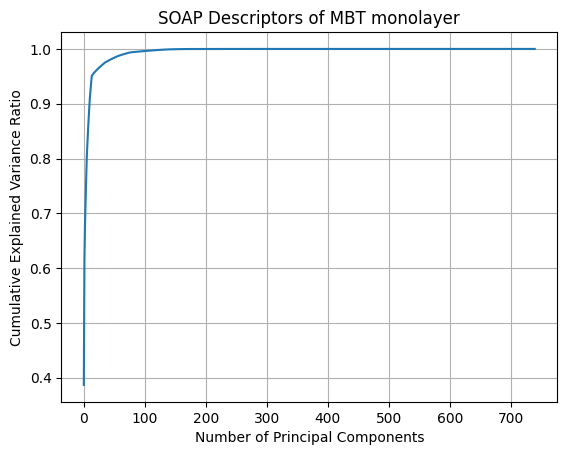

In [12]:
plot_PCA_variance(soap_desc,740)

In [13]:
def perform_pca(soap_desc, optimal_components):
    pca = PCA(n_components=optimal_components)
    soap_pca = pca.fit_transform(soap_desc)
    return soap_pca

In [14]:
optimized_pca = perform_pca(soap_desc,200)
optimized_pca_labelled = perform_pca(soap_desc_labelled,200)

In [15]:
print(optimized_pca.shape)
print(optimized_pca_labelled.shape)

(740, 200)
(240, 200)


In [16]:
scaler = StandardScaler()
X = scaler.fit_transform(optimized_pca)
X_labelled = scaler.fit_transform(optimized_pca_labelled)

latent_size = 64
input_dim = X.shape[1]

In [17]:
encoder_input = keras.Input(shape=(input_dim,))
encoder_hid_layer_1 = keras.layers.Dense(128, activation = 'selu')(encoder_input)
encoder_hid_layer_2 = keras.layers.Dense(96, activation = 'selu')(encoder_hid_layer_1)
encoder_output = keras.layers.Dense(64, activation = 'selu')(encoder_hid_layer_2)

In [18]:
decoder_hid_layer_1 = keras.layers.Dense(96, activation = 'selu')(encoder_output)
decoder_hid_layer_2 = keras.layers.Dense(128, activation = 'selu')(decoder_hid_layer_1)
decoder_output = keras.layers.Dense(input_dim, activation = 'linear')(decoder_hid_layer_2)

In [19]:
autoencoder = keras.models.Model(inputs = encoder_input, outputs = decoder_output)
autoencoder.compile(optimizer='adam', loss = 'mae',)

In [20]:
hist_autoencoder = autoencoder.fit(X, X, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9061 - val_loss: 0.6560
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6821 - val_loss: 0.5889
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6155 - val_loss: 0.5655
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5929 - val_loss: 0.5531
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5658 - val_loss: 0.5475
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5477 - val_loss: 0.5429
Epoch 7/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5354 - val_loss: 0.5403
Epoch 8/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5309 - val_loss: 0.5371
Epoch 9/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5267 - val_loss: 0.5362
Epoch 10/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5062 - val_loss: 0.5340
Epoch 11/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5164 - val_loss: 0.5312
Epoch 12/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3124 - val_loss: 0.5285
Epoch 138/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3175 - val_loss: 0.5271
Epoch 139/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3206 - val_loss: 0.5289
Epoch 140/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3166 - val_loss: 0.5301
Epoch 141/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3228 - val_loss: 0.5293
Epoch 142/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3108 - val_loss: 0.5296
Epoch 143/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3248 - val_loss: 0.5295
Epoch 144/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3179 - val_loss: 0.5299
Epoch 145/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3187 - val_loss: 0.5294
Epoch 146/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3197 - val_loss: 0.5306
Epoch 147/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3169 - val_loss: 0.5297
Epoch 148/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2855 - val_loss: 0.5468
Epoch 272/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2823 - val_loss: 0.5471
Epoch 273/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2747 - val_loss: 0.5473
Epoch 274/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2752 - val_loss: 0.5467
Epoch 275/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2717 - val_loss: 0.5474
Epoch 276/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2746 - val_loss: 0.5474
Epoch 277/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2785 - val_loss: 0.5469
Epoch 278/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2729 - val_loss: 0.5474
Epoch 279/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2817 - val_loss: 0.5480
Epoch 280/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2797 - val_loss: 0.5480
Epoch 281/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2761 - val_loss: 0.5481
Epoch 282/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2546 - val_loss: 0.5653
Epoch 406/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2485 - val_loss: 0.5633
Epoch 407/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2555 - val_loss: 0.5642
Epoch 408/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2527 - val_loss: 0.5647
Epoch 409/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2529 - val_loss: 0.5652
Epoch 410/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2538 - val_loss: 0.5638
Epoch 411/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2584 - val_loss: 0.5635
Epoch 412/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2592 - val_loss: 0.5642
Epoch 413/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2479 - val_loss: 0.5648
Epoch 414/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2543 - val_loss: 0.5655
Epoch 415/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2488 - val_loss: 0.5649
Epoch 416/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

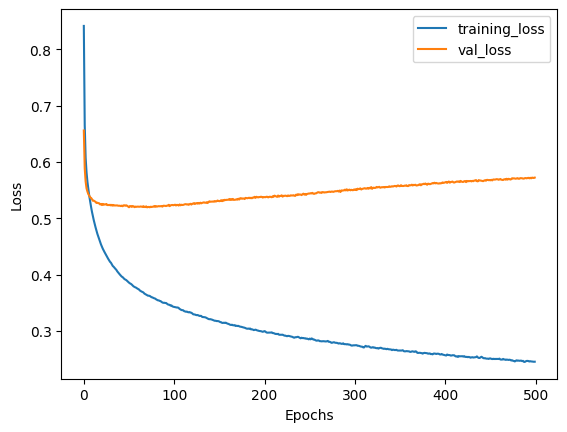

In [21]:
plt.plot(hist_autoencoder.history['loss'], label='training_loss')
plt.plot(hist_autoencoder.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [22]:
reconstructed_X = autoencoder.predict(X)
reconstructed_X_labelled = autoencoder.predict(X_labelled)

encoder = keras.models.Model(inputs = encoder_input, outputs = encoder_output)

compressed_X = encoder.predict(X)
compressed_X_labelled = encoder.predict(X_labelled)

print(compressed_X.shape)
print(compressed_X_labelled.shape)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(740, 64)
(240, 64)


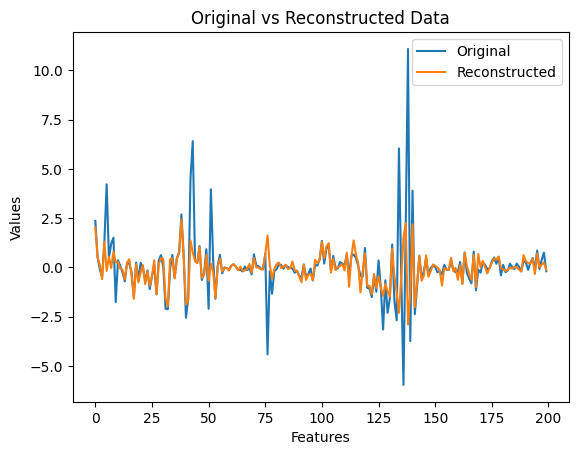

In [23]:
sample_idx = X[0]
plt.plot(X[0], label='Original')
plt.plot(reconstructed_X[0], label='Reconstructed')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Original vs Reconstructed Data')
plt.legend()
plt.show()

In [24]:
## FFNN

In [25]:
monolayer_MBT_DFT_data = pd.read_csv('id_props_240_labelled_data_MBT.csv')

In [26]:
y = monolayer_MBT_DFT_data[['Ef_per_cell','Mu_per_cell','Eg']]

In [27]:
ffnn_MBT = keras.models.Sequential([
    keras.layers.Dense(32, activation = 'selu', input_dim = latent_size),
    keras.layers.Dense(16, activation = 'selu'),
    keras.layers.Dense(8, activation = 'selu'),
    keras.layers.Dense(3, activation = 'linear')
])

C:\Users\Romakanta\Desktop\vENVs\vSOAP\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(compressed_X_labelled, y, test_size = 0.2, random_state = 1)

In [29]:
ffnn_MBT.compile(optimizer = 'adam', loss = 'mae')
hist_ffnn_MBT = ffnn_MBT.fit(X_train, y_train, epochs = 500, batch_size = 32, validation_split = 0.2)

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 2.1596 - val_loss: 2.0089
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8573 - val_loss: 1.8556
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7150 - val_loss: 1.7214
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5792 - val_loss: 1.5984
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4623 - val_loss: 1.4842
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3428 - val_loss: 1.3899
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2623 - val_loss: 1.3072
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1442 - val_loss: 1.2384
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0463 - val_loss: 1.1821
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9382 - val_loss: 1.1297
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9214 - val_loss: 1.0878
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7945 - val_lo

Epoch 70/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2323 - val_loss: 0.8036
Epoch 71/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2204 - val_loss: 0.8042
Epoch 72/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1819 - val_loss: 0.7971
Epoch 73/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1833 - val_loss: 0.7963
Epoch 74/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2053 - val_loss: 0.7960
Epoch 75/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1855 - val_loss: 0.7954
Epoch 76/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1918 - val_loss: 0.7962
Epoch 77/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1965 - val_loss: 0.8008
Epoch 78/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1779 - val_loss: 0.7924
Epoch 79/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1847 - val_loss: 0.7903
Epoch 80/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1734 - val_loss: 0.7966
Epoch 81/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1714 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0484 - val_loss: 0.8500
Epoch 207/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0491 - val_loss: 0.8502
Epoch 208/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0429 - val_loss: 0.8515
Epoch 209/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0467 - val_loss: 0.8542
Epoch 210/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0394 - val_loss: 0.8531
Epoch 211/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0459 - val_loss: 0.8501
Epoch 212/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0522 - val_loss: 0.8486
Epoch 213/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0494 - val_loss: 0.8585
Epoch 214/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0487 - val_loss: 0.8578
Epoch 215/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0480 - val_loss: 0.8520
Epoch 216/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0450 - val_loss: 0.8487
Epoch 217/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0517 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257 - val_loss: 0.8687
Epoch 343/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0279 - val_loss: 0.8667
Epoch 344/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0307 - val_loss: 0.8772
Epoch 345/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0293 - val_loss: 0.8741
Epoch 346/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0271 - val_loss: 0.8760
Epoch 347/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0284 - val_loss: 0.8713
Epoch 348/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0296 - val_loss: 0.8739
Epoch 349/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0300 - val_loss: 0.8745
Epoch 350/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0305 - val_loss: 0.8746
Epoch 351/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0246 - val_loss: 0.8719
Epoch 352/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266 - val_loss: 0.8779
Epoch 353/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248 - v

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 - val_loss: 0.8796
Epoch 479/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0239 - val_loss: 0.8745
Epoch 480/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 - val_loss: 0.8730
Epoch 481/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0246 - val_loss: 0.8795
Epoch 482/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0254 - val_loss: 0.8743
Epoch 483/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0261 - val_loss: 0.8766
Epoch 484/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0248 - val_loss: 0.8719
Epoch 485/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0253 - val_loss: 0.8722
Epoch 486/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0203 - val_loss: 0.8745
Epoch 487/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212 - val_loss: 0.8752
Epoch 488/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0183 - val_loss: 0.8767
Epoch 489/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - v

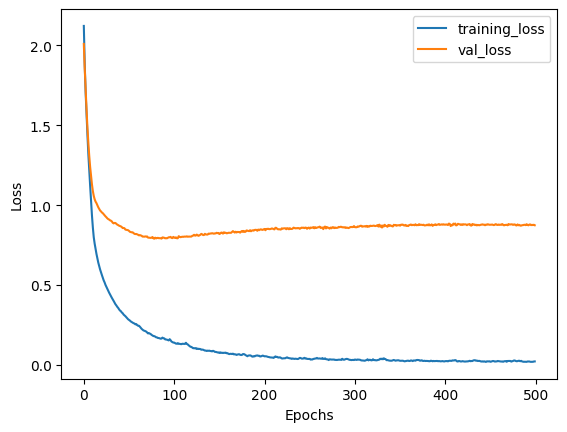

In [30]:
plt.plot(hist_ffnn_MBT.history['loss'], label='training_loss')
plt.plot(hist_ffnn_MBT.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [31]:
pred_train = ffnn_MBT.predict(X_train)
pred_test = ffnn_MBT.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


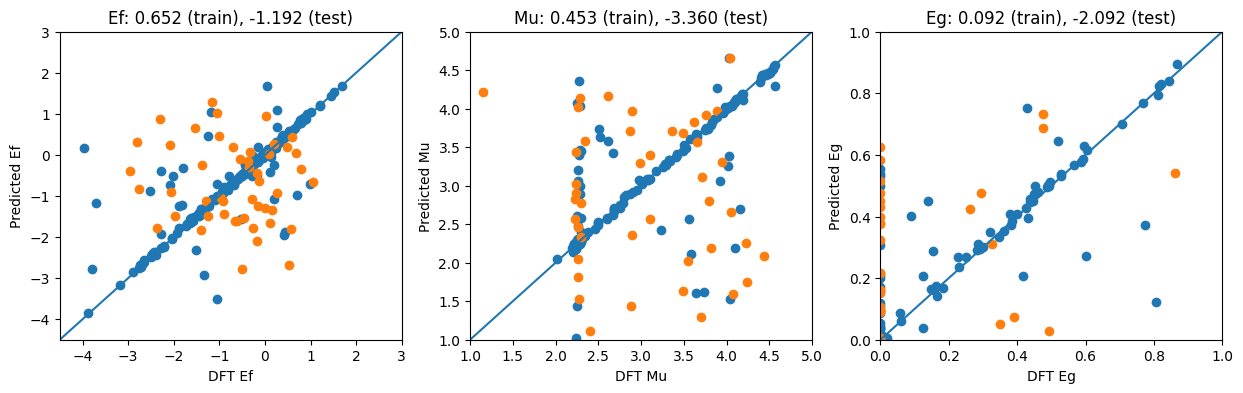

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize = (15,4))
ax1.scatter(y_train['Ef_per_cell'], pred_train[:,0])
ax1.scatter(y_test['Ef_per_cell'], pred_test[:,0])
ax1.plot([-4.5, 3], [-4.5, 3])

ax2.scatter(y_train['Mu_per_cell'], pred_train[:,1])
ax2.scatter(y_test['Mu_per_cell'], pred_test[:,1])
ax2.plot([0, 5], [0, 5])

ax3.scatter(y_train['Eg'], pred_train[:,2])
ax3.scatter(y_test['Eg'], pred_test[:,2])
ax3.plot([0, 1], [0, 1])

ax1.set_title('Ef: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]),metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0])))
ax2.set_title('Mu: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]),metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1])))
ax3.set_title('Eg: {:.3f} (train), {:.3f} (test)'.format(metrics.r2_score(y_train['Eg'], pred_train[:,2]),metrics.r2_score(y_test['Eg'], pred_test[:,2])))

ax1.set_xlabel('DFT Ef')
ax1.set_ylabel('Predicted Ef')

ax2.set_xlabel('DFT Mu')
ax2.set_ylabel('Predicted Mu')

ax3.set_xlabel('DFT Eg')
ax3.set_ylabel('Predicted Eg')

ax1.set_xlim([-4.5, 3])
ax1.set_ylim([-4.5, 3])

ax2.set_xlim([1, 5])
ax2.set_ylim([1, 5])

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

plt.show()

In [33]:
print(metrics.r2_score(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.r2_score(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.r2_score(y_train['Eg'], pred_train[:,2]))

0.651892711915615
0.4527358600234582
0.09153768274517016


In [34]:
print(metrics.mean_absolute_error(y_train['Ef_per_cell'], pred_train[:,0]))
print(metrics.mean_absolute_error(y_train['Mu_per_cell'], pred_train[:,1]))
print(metrics.mean_absolute_error(y_train['Eg'], pred_train[:,2]))

0.2569200202757883
0.23793399601802226
0.0854149146134965


In [35]:
print(metrics.r2_score(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.r2_score(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.r2_score(y_test['Eg'], pred_test[:,2]))

-1.1916853865151693
-3.3604928116936836
-2.0918872514584868


In [36]:
print(metrics.mean_absolute_error(y_test['Ef_per_cell'], pred_test[:,0]))
print(metrics.mean_absolute_error(y_test['Mu_per_cell'], pred_test[:,1]))
print(metrics.mean_absolute_error(y_test['Eg'], pred_test[:,2]))

1.1693094956397327
1.2282693183024724
0.322229510272791
